# So sánh dự báo LTSF với FPT_hidden-test

Notebook này tải toàn bộ file dự báo trong thư mục `submissions`, đối chiếu với dữ liệu thực tế `FPT_hidden-test.csv`, tính toán các chỉ số RMSE/MAE/MSE/R² và trực quan hóa top mô hình.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('seaborn-v0_8')

In [2]:
hidden_df = pd.read_csv('FPT_hidden-test.csv')
hidden_df['time'] = pd.to_datetime(hidden_df['time'])
hidden_df = hidden_df.sort_values('time').reset_index(drop=True)
hidden_close = hidden_df['close'].astype(float).values
print(f"FPT_hidden-test length: {len(hidden_df)} rows from {hidden_df['time'].min().date()} to {hidden_df['time'].max().date()}")
display(hidden_df.head())

FPT_hidden-test length: 69 rows from 2025-03-10 to 2025-06-18


,time,open,high,low,close,volume,symbol
0,2025-03-10,122.00,122.00,120.02,120.11,5343134,FPT
1,2025-03-11,118.98,119.42,118.12,118.55,5801595,FPT
2,2025-03-12,118.73,119.59,117.17,117.17,6229823,FPT
3,2025-03-13,117.35,118.98,117.35,117.69,3630282,FPT
4,2025-03-14,116.92,117.52,112.78,113.29,16174178,FPT


In [3]:
submissions_dir = 'submissions'
forecast_files = sorted([f for f in os.listdir(submissions_dir) if f.startswith('submission_') and f.endswith('_100d.csv')])
if not forecast_files:
    raise FileNotFoundError('Không tìm thấy file dự báo trong thư mục submissions.')

records = []
max_len = len(hidden_close)
for filename in forecast_files:
    file_path = os.path.join(submissions_dir, filename)
    forecast_df = pd.read_csv(file_path)
    preds = forecast_df['close'].astype(float).values
    aligned_len = min(len(preds), max_len)
    preds_clip = preds[:aligned_len]
    actual_clip = hidden_close[:aligned_len]
    mse = mean_squared_error(actual_clip, preds_clip)
    mae = mean_absolute_error(actual_clip, preds_clip)
    rmse = np.sqrt(mse)
    try:
        r2 = r2_score(actual_clip, preds_clip)
    except ValueError:
        r2 = np.nan
    slug = filename.replace('submission_', '').replace('_100d.csv', '')
    model_name, horizon = slug.split('_', 1)
    records.append({
        'Model': model_name,
        'Horizon': horizon,
        'ForecastFile': file_path,
        'AlignedLength': aligned_len,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    })

comparison_df = pd.DataFrame(records).sort_values('RMSE').reset_index(drop=True)
print('Bảng so sánh theo RMSE tăng dần:')
display(comparison_df)

Bảng so sánh theo RMSE tăng dần:


,Model,Horizon,ForecastFile,AlignedLength,RMSE,MAE,MSE,R2
0,nlinear,480d,submissions/submission_nlinear_480d_100d.csv,69,18.362144,16.493689,337.168339,-7.053688
1,linear,120d,submissions/submission_linear_120d_100d.csv,69,19.198660,17.816875,368.588562,-7.804199
2,dlinear,120d,submissions/submission_dlinear_120d_100d.csv,69,20.755877,19.677889,430.806430,-9.290351
3,dlinear,7d,submissions/submission_dlinear_7d_100d.csv,69,21.879157,20.612061,478.697530,-10.434289
4,linear,7d,submissions/submission_linear_7d_100d.csv,69,22.000841,20.721156,484.037001,-10.561829
5,linear,30d,submissions/submission_linear_30d_100d.csv,69,22.736915,21.539710,516.967296,-11.348411
6,nlinear,120d,submissions/submission_nlinear_120d_100d.csv,69,23.775222,22.391828,565.261164,-12.501970
7,nlinear,30d,submissions/submission_nlinear_30d_100d.csv,69,24.117266,22.834954,581.642496,-12.893259
8,dlinear,30d,submissions/submission_dlinear_30d_100d.csv,69,24.555424,23.243427,602.968851,-13.402665
9,nlinear,7d,submissions/submission_nlinear_7d_100d.csv,69,26.298399,24.723766,691.605775,-15.519869


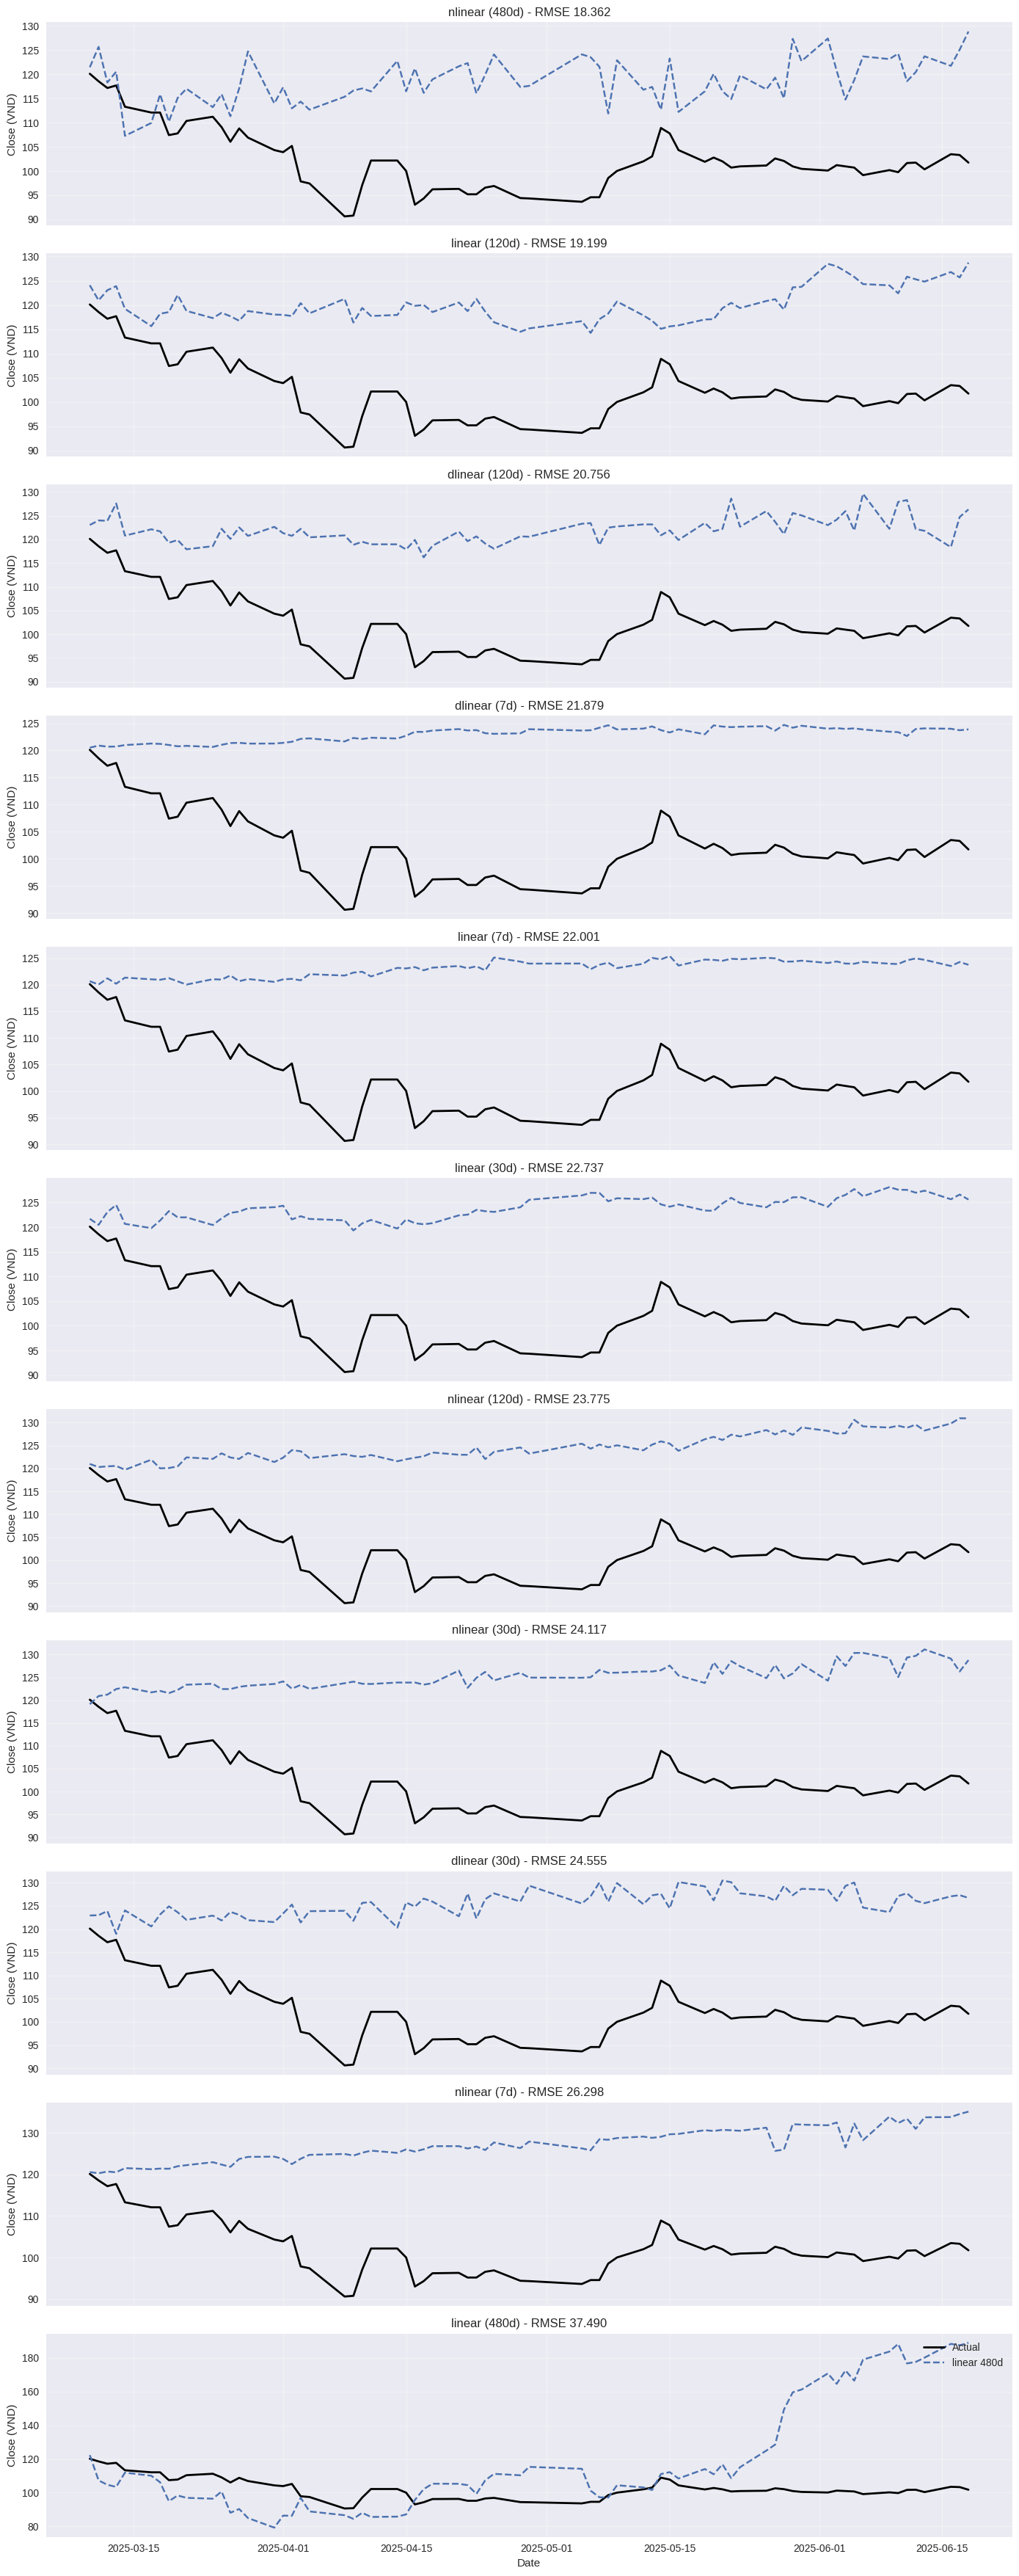

In [6]:
# top_k = min(4, len(comparison_df))
top_k = 11
if top_k == 0:
    print('Không có bản ghi để vẽ.')
else:
    fig, axes = plt.subplots(top_k, 1, figsize=(14, 3.2 * top_k), sharex=True)
    if top_k == 1:
        axes = [axes]
    for ax, (_, row) in zip(axes, comparison_df.head(top_k).iterrows()):
        forecast_df = pd.read_csv(row['ForecastFile'])
        preds = forecast_df['close'].astype(float).values
        aligned_len = min(len(preds), len(hidden_close))
        ax.plot(hidden_df['time'][:aligned_len], hidden_close[:aligned_len], label='Actual', color='black', linewidth=2)
        ax.plot(hidden_df['time'][:aligned_len], preds[:aligned_len], label=f"{row['Model']} {row['Horizon']}", linestyle='--')
        ax.set_title(f"{row['Model']} ({row['Horizon']}) - RMSE {row['RMSE']:.3f}")
        ax.set_ylabel('Close (VND)')
        ax.grid(True, alpha=0.3)
    axes[-1].set_xlabel('Date')
    axes[-1].legend(loc='upper right')
    plt.tight_layout()
    plt.show()

In [5]:
output_path = 'submissions/fpt_hidden_test_comparison.csv'
comparison_df.to_csv(output_path, index=False)
print(f'Saved comparison summary to {output_path}')

Saved comparison summary to submissions/fpt_hidden_test_comparison.csv
